In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用三阶多项式生成训练和测试数据的标签

In [3]:
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集大小
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i]/=math.gamma(i+1)
# labels的维度是(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1,size=labels.shape)


In [4]:
# NumPy ndarrray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32)
                                          for x in [true_w, features, poly_features, labels]]
features[:2],poly_features[:2,:],labels[:2]

(tensor([[-0.5625],
         [ 0.3142]]),
 tensor([[ 1.0000e+00, -5.6255e-01,  1.5823e-01, -2.9670e-02,  4.1727e-03,
          -4.6947e-04,  4.4017e-05, -3.5373e-06,  2.4874e-07, -1.5547e-08,
           8.7462e-10, -4.4728e-11,  2.0968e-12, -9.0735e-14,  3.6459e-15,
          -1.3673e-16,  4.8074e-18, -1.5908e-19,  4.9717e-21, -1.4720e-22],
         [ 1.0000e+00,  3.1416e-01,  4.9348e-02,  5.1677e-03,  4.0587e-04,
           2.5501e-05,  1.3352e-06,  5.9926e-08,  2.3533e-09,  8.2145e-11,
           2.5806e-12,  7.3703e-14,  1.9295e-15,  4.6629e-17,  1.0464e-18,
           2.1915e-20,  4.3030e-22,  7.9518e-24,  1.3879e-25,  2.2948e-27]]),
 tensor([3.6136, 5.0859]))

对模型进行训练和测试

In [6]:
import Ipynb_importer
import softmax_from0
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = softmax_from0.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

现在定义训练函数

In [7]:
def train(train_features, test_features, train_labels,test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设偏置值，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = softmax_from0.Animator(xlabel='epoch', ylabel='loss',yscale='log',
                                     xlim=[1,num_epochs], ylim=[1e-3, 1e2],
                                     legend=['train','test'])
    for epoch in range(num_epochs):
        softmax_from0.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch+1)%20==0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss),
                                  evaluate_loss(net, test_iter, loss)))
    print('weight:',net[0].weight.data.numpy())
    

三阶多项式函数拟合

weight: [[ 5.0098686  1.2098813 -3.4274476  5.6184406]]


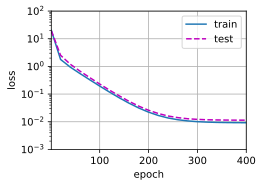

In [8]:
# 从多现实特征选择前4个维度，即1，x，x^2/2!，x^3/3!
train(poly_features[:n_train,:4],poly_features[n_train:,:4],
     labels[:n_train],labels[n_train:])

weight: [[3.9234297 3.0248473]]


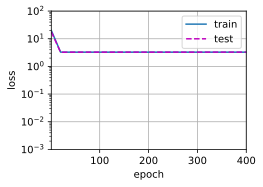

In [9]:
# 从多项式特征中选择两个维度1，x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
     labels[:n_train], labels[n_train:])

高阶多项式函数拟合

weight: [[ 5.0095654   1.2634518  -3.3892586   5.3535957  -0.20411366  0.80647373
  -0.11647344 -0.05022831 -0.18693587  0.1708779  -0.15905598  0.05513055
  -0.21051209 -0.03285559  0.15106586 -0.03992658 -0.21436627  0.19206157
   0.13592267 -0.05200483]]


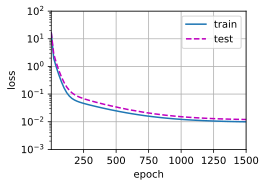

In [10]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train,:], poly_features[n_train:,:],
     labels[:n_train], labels[n_train:], num_epochs=1500)